# Noncovalent interactions and NMR observables
## Some ideas for the NONCOV Toolbox in Python

### Ettore Bartalucci, Progress Report 17.09.2024

## Introduction

* Noncovalent interactions are electromagnetic interactions between molecules that either completely exchange (not share) electrons or not exchange electrons at all

* They are critical in molecular recognition events e.g. cocrystal formations ecc

* They can can be experimentally detected from NMR parameters (e.g. changes in $\sigma_{iso}$)

* Some examples are listed in the table below:

| Electrostatic | Van der Waals | $\pi$ interactions | Other |
| --- | --- | --- | --- |
| Ionic bond | dipole-dipole | $\pi$-$\pi$ | Hydrophobic |
| H-bond | dipole-induced dipole | Cation/Anion-$\pi$ | Hydrophilic |
| Halo-bond | London dispersion | Polar-$\pi$ |  |


The components of the shielding tensor are given by:

$$
\sigma_{a,b} = \frac{\partial^2 E}{\partial \mu_a \partial B_b}
$$

where E is the total electronic structure of the molecule, B is the external magnetic fdield and $\mu$ is the magnetic moment of the nucleus of interest.

The shielding tensor in Cartesian frame fixed to the molecule has nine independent components, which can be reduced by choosing a reference system that reflects the symmetry of the molecule (PAS). Also, the diamagnetic contribution to the shielding tensor is a symmetric quantity.

$$
\sigma =  \begin{bmatrix}
           \sigma_{xx} & \sigma_{xy} & \sigma_{xz}\\
           \sigma_{yx} & \sigma_{yy} & \sigma_{yz}\\
           \sigma_{zx} & \sigma_{zy} & \sigma_{zz}
           \end{bmatrix}
$$ 

The chemical shielding tensor is anisotropic, depending not only on the local chemical and electronic structure but also on the orientation in magnetic field.

The nine independent components of the tensor can be decomposed in symmetric and antysimmetric parts:

$$
\sigma = \sigma^S + \sigma^A
$$

$$
\sigma^S = \frac{1}{2} (\sigma + \sigma^T)
$$

$$
\sigma^A = \frac{1}{2} (\sigma - \sigma^T)
$$

$\sigma^A$ doesnt contribute to the spectral frequency since its zz component is zero for all orientations of the molecule so we ignore it here.


The indirect spin-spin coupling constant observed in NMR spectra between two nuclei $i$ and $k$ is the second derivative of the electronic energy with respect to the nuclear magnetic moments $m_i$ and $m_j$:

$$
J^{ik} = \frac{\partial^2E}{\partial m_i \partial m_k}
$$

and consist of four distinct contributions namely the diamagnetic spin-orbit contribution (DSO) which is the expectation value of the ground state wave function, the paramagnetic spin-orbit (PSO), Fermi contact (FC) and spin-dipole (SD) contributions.

$$ 
H_{DSO} = \frac{1}{2} \sum_{ikl} \frac{(M_k \times r_{ik})(M_l \times r_{il})}{r_{ik}^3 r_{il}^3}
$$

$$
H_{PSO} = \sum_{ik} \frac{M_k l_{ik}}{r_{ik}^3}
$$

$$
H_{FC} = \frac{8 \pi}{3} \sum_{ik} \delta(r_i - r_k) m_k
$$

$$
H_{SD} = \sum_{ik} m_k^T \frac{3 r_{ik}r_{ik}^T - r_{ik}^2}{r_{ik}^5} s_i
$$

Where the Fermi contact is the most significant contribution (usually).


However, some of the questions that are yet to be answered are:

* How sensitive are individual nuclei to NCIs?
* How is the response of each nucleus to different NCI? e.g. are there preferential ones?
* Whats the geometric response of NMR observables undergoing NCIs?
* Is it possible to separate the contributions of each NCIs to a selected observable of interest?
* BONUS: Can we machine learn these trends?

## Structure

For ease of showing the various steps, i will use the benzene+H20 complex as example throughout the presentation.

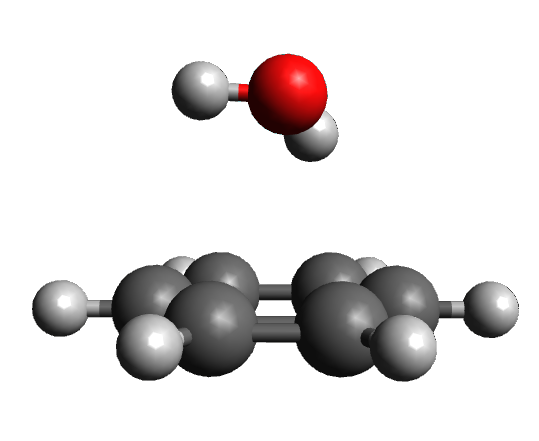

This project works thanks to:

<p float="left">
  <img src="oreilymeme1.png" width="350" />
  <img src="oreilymeme2.png" width="350" /> 
</p>


```mermaid
graph TD
nci["Choose NCI
    fragments
    / Compund Jobs"] --> dft("Relax structures
                        @DFT")
    
    dft -->|HPC@MPI| crest["in-silico 
                            CREST/CENSO l.e.c."]
    dft -->|StructureModifier| displace[Displace fragments]
    dft -->|StructureModifier| rotate[Rotate Fragments]

    crest --> nmr["Compute 
                    NMR parameters"]
    displace --> nmr["Compute 
                    NMR parameters"]
    rotate --> nmr["Compute 
                    NMR parameters"]

    nmr -->postproc["General
                    postprocessing"]
    postproc --> sigma[Shielding Tensor]
    postproc --> j[J coupling Tensor]
    postproc --> meyer[Meyer B.O.]
    postproc --> else[Anything else?]

    sigma --> ml[Input for ML dataframe]
    j --> ml[Input for ML dataframe]
    meyer --> ml[Input for ML dataframe]
    else --> ml[Input for ML dataframe]

    sigma --> view[Plots]
    j --> view[Plots]
    meyer --> view[Plots]
    else --> view[Plots]

    ml --> predictions["Predict NCI
                        contribution %
                        to NMR parameters"]
```

Two types of datasets for Machine learning:


```mermaid
graph LR
nuc["Single-nucleus
    properties"] --> shift[e.g. shielding tensor] --> 1[nuc_prop_nmr_observables] 
    
pair["Pairwise
    properties"] --> coup[e.g. J coupling] --> 2[pairwise_nuc_prop_nmr_observables] 
```

## Preconfig NONCOVToolbox Library

In [1]:
# Get the NONCOVToolbox library and print header
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.cluster import KMeans
import pathlib as Path

path_noncov = os.path.abspath(os.path.join('..', 'src'))

if path_noncov not in sys.path:
    sys.path.append(path_noncov)

from noncov import NONCOVToolbox, NONCOVHeader

noncov = NONCOVToolbox()

#NONCOVHeader.print_header()

# Pre work on molecular geometries
from noncov import StructureModifier

# OrcaAnalysis module for postprocessing of DFT calculations
from noncov import OrcaAnalysis

# Graph molecular representations
from noncov import MolecularGraph

# Functions to store data in dataframes
from noncov import MachineLearning

# Show performance and features of various NMR functions in module
from noncov import NMRFunctions

# Display the molecule while its displaced, not yet interactive in Jupyter but interactive in VS Code
from noncov import MolView

# Disable printing
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore printing
def enablePrint():
    sys.stdout = sys.__stdout__

In [ ]:
# Get configuration file 
configdir = os.getcwd()
configdir = os.path.abspath(os.path.join('..', 'config'))

configs = os.path.join(configdir, 'configuration.yml')
print(f'Change with care, configuration file is in:', configs)

print('And looks like this...\n')
with open(configs,'r') as f:
    config_file = f.read()
    print(config_file)

In [2]:
# Get work directory and scratch folder for the output data
current_dir = os.getcwd()
print(f'Current work directory is: {current_dir}')

scratch_dir = os.path.abspath(os.path.join('..', 'scratch'))
print(f'Current scratch directory is: {scratch_dir}')
scratch_dir = OrcaAnalysis().convert_path(scratch_dir)

test_dir = os.path.abspath(os.path.join('..', 'tests'))
print(f'Current test directory is: {test_dir}')
test_dir = OrcaAnalysis().convert_path(test_dir)

mol_dir = os.path.join(scratch_dir, 'StructureModifier/input_structures/benzene_H2O.xyz')
print(f'Current molecule directory is: {mol_dir}')
mol_dir = OrcaAnalysis().convert_path(mol_dir)

Current work directory is: D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\results
Current scratch directory is: D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\scratch
Normalized path using os.path: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch
Current test directory is: D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\tests
Normalized path using os.path: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/tests
Current molecule directory is: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch\StructureModifier/input_structures/benzene_H2O.xyz
Normalized path using os.path: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/StructureModifier/input_structures/benzene_H2O.xyz


## Modules: GenerateMLDataset

In [45]:
# RUN THIS CELL ONLY IF YOU NEVER CREATED THE EMPTY DATASET BEFORE
datasets_dir = os.path.join(scratch_dir, 'GenerateMLDataset/data/')
print(f'Dataset directory is: {datasets_dir}')
datasets_dir = OrcaAnalysis().convert_path(datasets_dir)

if os.listdir(datasets_dir) == []:
    print("No files found in the directory, creating datasets... \n")
    # Make the dataset for the pairwise NMR properties
    MachineLearning().make_empty_pairwise_prop_df(datasets_dir)
    
    # Make the dataset for the individual NMR properties
    MachineLearning().make_empty_nuc_prop_df(datasets_dir)
else:
    print("Some files found in the directory, skipping... \n")

In [46]:
# Display how the empty databases look like
nucprop = os.path.join(datasets_dir, 'nuc_prop_nmr_observables.csv')
nucprop_df = pd.read_csv(nucprop)

pw_nucprop = os.path.join(datasets_dir, 'pairwise_nuc_prop_nmr_observables.csv')
pw_nucprop_df = pd.read_csv(pw_nucprop)

In [ ]:
nucprop_df

In [ ]:
pw_nucprop_df

## Example of CREST

## Module: StructureModifier

Take a relaxed xyz structure with two interacting fragments and displace them relative to each other along the vector connecting the two centroids:

$$ 
p_{new} = p_{old} + \hat{d} \cdot s \cdot i
$$

where $p$ are the new and old coordinates respectively, $\hat{d}$ is the normalized displacement direction vector, $s$ is the step size and $i$ is the number of iterations you want.

In [14]:
# Relative paths
start_structure = os.path.join(scratch_dir, 'StructureModifier/input_structures/benzene_H2O_relaxH.xyz')
molecule_name = os.path.splitext(os.path.basename(start_structure))[0]

centroid_out = os.path.join(scratch_dir, f'StructureModifier/centroid_output/{molecule_name}_centroid_file.xyz')
input_file = os.path.join(scratch_dir, 'StructureModifier/input_file/input_file.txt')

In [15]:
# Print an example of input file
with open(input_file, 'r') as file:
    input_content = file.read()
    print(input_content)

$fragment2
1
2
3
4
5
6
7
8
9
10
11
12
$fragment1
13
14
15
$displacement
0.25



In [16]:
# Read xyz file: this should be either a fully optimized geometry or one with relaxed H or a CREST conformer
coordinates, atom_identities = StructureModifier().read_atomic_coord(start_structure)
#print(f'Starting coordinates: {coordinates}')
#print(f'Atom identities: {atom_identities}')

In [17]:
# Assign coordinates to molecular fragments, check nomenclature of your atoms in avogadro or any other molecular graphics sof
coords1, coords2 = StructureModifier().assign_molecule_fragments(coordinates, input_file)

# Concatenate coordinates for k-means clustering
all_coords = np.concatenate((coords1, coords2), axis=0)
# print(f'All coords: {all_coords}')

# Count how many fragments you have defined in the input file, important for accurate K-means clustering
n_fragments = StructureModifier().count_fragments(input_file)
print(f"Number of '$fragment': {n_fragments}")

Number of '$fragment': 2


In [18]:
# Perform k-means clustering to compute centroids
kmeans = KMeans(n_clusters=n_fragments) # K-means clusters = number of centroids = number of fragments
kmeans.fit(all_coords)
centroids = kmeans.cluster_centers_

# Compute centroids for each fragment
fragment_centroids = StructureModifier().calculate_centroids([coords1, coords2])

# Write centroid coordinates to file
StructureModifier().write_centroids(centroid_out, fragment_centroids)
#print(f'Centroid coordinates: {fragment_centroids}')

In [19]:
# Calculate displacement direction (line connecting centroids)
displacement_direction = fragment_centroids[0,:] - fragment_centroids[1,:]
displacement_direction /= np.linalg.norm(displacement_direction)
print(f'Displacement direction:{displacement_direction}')

Displacement direction:[0.00170198 0.99491646 0.10068935]


In [20]:
# Read displacement step size from input file
displacement_step = None
with open(input_file, 'r') as f:
    lines = f.readlines()
    read_displacement = False
    for line in lines:
        if read_displacement:
            displacement_values = line.strip().split()
            if displacement_values:
                displacement_step = float(displacement_values[0])
                break
        elif line.strip() == "$displacement":
            read_displacement = True

if displacement_step is None:
    print('ERROR: displacement step size not found in input file, please specify it! Syntax => $displacement + number')
print(f'Displacement step is: {displacement_step} Angstroem') # please doublecheck that it is the same value you defined in the input

Displacement step is: 0.25 Angstroem


In [21]:
# Displace the first fragment iteratively and save each structure
displaced_fragment_coords = coords1.copy()  # Make a copy of the original coordinates of the fragment that is displaced
#print(f'Original coordinates displaced fragment:', displaced_fragment_coords)

# Initialize the coordinates for the fixed fragment (e.g., coords2)
coords_fixed = coords2.copy() # make a copy of the fixed fragment coordinates to append to the displaced ones
#print(f'Original coordinates fixed fragment:', coords_fixed)

all_displaced_fragment_coords = [displaced_fragment_coords]  # List to store all displaced structures

# Combine displaced coordinates with original ones
all_combined_coords = [np.concatenate((coords_fixed, displaced_fragment_coords), axis=0)]  # List to store all combined structures

fragment_centroids = [fragment_centroids[0]]  # List to store all centroids

In [22]:
# Dissociation limit NEED AT LEAST 40 OF THEM MINIMUM
diss_lim = 20 # ANY IDEA HOW TO CALCULATE?

for i in range(0, diss_lim):  # Iterate 50 times (adjust the number as needed) 

    displacement_vector = [] 

    # Compute new set of coordinates for displaced fragments, change $displacement value in input file to tune the displacement
    displaced_fragment_coords = StructureModifier().displace_fragment(coords1, displacement_direction, displacement_step, i)
    #print(f'Displaced fragment coord is: {displaced_fragment_coords}')

    combined_coords = np.concatenate((coords_fixed, displaced_fragment_coords), axis=0)
    all_combined_coords.append(combined_coords)

    # Update centroids for the displaced structure
    fragment_centroid = StructureModifier().calculate_centroids([displaced_fragment_coords])
    fragment_centroids.append(fragment_centroid[0])
    #print(f'Updated centroids:', fragment_centroid)
    
    # Write displaced structure to file
    output_file = os.path.join(scratch_dir, f'StructureModifier/displaced_structures/{molecule_name}_disp_struct_{i}.xyz')
    StructureModifier().write_displaced_xyz_file(output_file, coords_fixed, displaced_fragment_coords, atom_identities)

    all_displaced_fragment_coords.append(displaced_fragment_coords)

    # Compute distance between the fixed fragment centroid and all the atoms from the displaced fragment
    centroid_to_displaced_distance = StructureModifier().compute_distance_from_centroid(displaced_fragment_coords, centroids)
    #print(f'Distance between displaced coordinates and centroid is: {centroid_to_displaced_distance}')

    # Write distances to file - needed for DFT calculations outputs
    distance_output_file = os.path.join(scratch_dir, f'StructureModifier/distance_files/{molecule_name}_distances_{i}.xyz')

    StructureModifier().write_distances_file(distance_output_file, displaced_fragment_coords, centroid_to_displaced_distance, atom_identities, displacement_step)

Displacement vector: [0. 0. 0.]
<class 'numpy.ndarray'>
Displacement vector: [0.0004255  0.24872911 0.02517234]
<class 'numpy.ndarray'>
Displacement vector: [0.00085099 0.49745823 0.05034468]
<class 'numpy.ndarray'>
Displacement vector: [0.00127649 0.74618734 0.07551702]
<class 'numpy.ndarray'>
Displacement vector: [0.00170198 0.99491646 0.10068935]
<class 'numpy.ndarray'>
Displacement vector: [0.00212748 1.24364557 0.12586169]
<class 'numpy.ndarray'>
Displacement vector: [0.00255297 1.49237469 0.15103403]
<class 'numpy.ndarray'>
Displacement vector: [0.00297847 1.7411038  0.17620637]
<class 'numpy.ndarray'>
Displacement vector: [0.00340396 1.98983291 0.20137871]
<class 'numpy.ndarray'>
Displacement vector: [0.00382946 2.23856203 0.22655105]
<class 'numpy.ndarray'>
Displacement vector: [0.00425495 2.48729114 0.25172339]
<class 'numpy.ndarray'>
Displacement vector: [0.00468045 2.73602026 0.27689573]
<class 'numpy.ndarray'>
Displacement vector: [0.00510594 2.98474937 0.30206806]
<class '

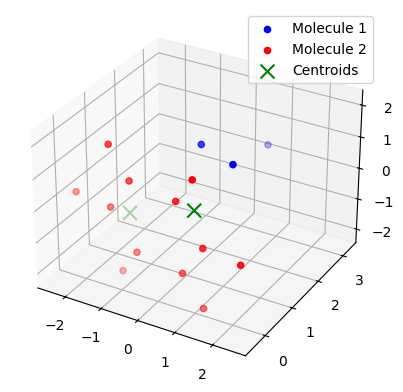

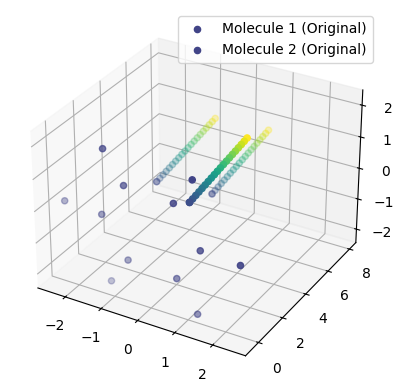

In [23]:
# Plot initial topology for molecular fragments and centroids
fig = StructureModifier().plot_starting_molecular_fragments(coords1, coords2, centroids)

# Generate colors for the plots based on displacement iteration
num_iterations = len(all_displaced_fragment_coords)
colors = plt.cm.viridis(np.linspace(0.2, 1.0, num_iterations))

# Plot displaced molecular fragments and centroids
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot original fragments and centroids
ax.scatter(coords1[:, 0], coords1[:, 1], coords1[:, 2], color=colors[0], label='Molecule 1 (Original)')
ax.scatter(coords2[:, 0], coords2[:, 1], coords2[:, 2], color=colors[0], label='Molecule 2 (Original)')
#ax.scatter(centroids[0, 0], centroids[:, 1], centroids[:, 2], color=colors[0], marker='x', s=100, label='Centroids (Original)')

# Plot displaced fragments and centroids
for i, displaced_coords in enumerate(all_displaced_fragment_coords[1:], start=1):
    color = colors[i]
    label = f'Iteration {i}'
    ax.scatter(displaced_coords[:, 0], displaced_coords[:, 1], displaced_coords[:, 2], color=color)
    #ax.scatter(fragment_centroids[i][0], fragment_centroids[i][1], fragment_centroids[i][2], color=color)

    #ax.scatter(displaced_coords[:, 0], displaced_coords[:, 1], displaced_coords[:, 2], color=color, label=label)
    #ax.scatter(fragment_centroids[i][0], fragment_centroids[i][1], fragment_centroids[i][2], color=color, marker='x', s=100, label=f'Centroids ({label})')

ax.legend()
plt.show()

## Modules: OrcaAnalysis

here some description

In [24]:
# Provide files you want to process as input 
#"C:\Users\ettor\Desktop\NONCOV\tests\data\run_all_displaced_distances.mpi8.out"
orca_output = input("Enter the path to the ORCA file you want to work with: ")
orca_output = OrcaAnalysis().convert_path(orca_output)

Enter the path to the ORCA file you want to work with:  "D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\tests\test_data\run_all_displaced_distances.mpi8.out"


Normalized path using os.path: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/tests/test_data/run_all_displaced_distances.mpi8.out


In [38]:
split_file_name = os.path.splitext(os.path.basename(orca_output))[0]

In [39]:
split_file_name

'run_all_displaced_distances.mpi8'

In [40]:
# Working with ORCA .out files

# Count how many sequential calculations have been done
n_jobs = OrcaAnalysis().count_jobs_number(orca_output)
print(f'Number of ORCA jobs in file: {n_jobs}\n')

# Compute size of the .out file and suggest Git LFS 
size_orca_output = os.path.getsize(orca_output)
size_orca_output = size_orca_output/1e6
print(f'Size of ORCA file is: {size_orca_output} MB\n')

if n_jobs > 20:
    print(f'Careful, you are working with a possibly large output file of several GB\n')
    print(f'If using version controls consider setting up a .gitignore \n')

if size_orca_output > 1:
    print(f"Careful, you are working with a '{size_orca_output}' KB large file..\n")
    print(f'Set up a .gitignore or Git LFS before pushing to Git\n')

# Extract level of theory
lot_out = OrcaAnalysis().extract_level_of_theory(orca_output)
print(f'Level of theory for the NMR calculations is: {lot_out}\n')

# Get a list of all the molecule names in the calculation, needed for ML later
list_molecules = OrcaAnalysis().extract_molecule_names(orca_output)
print(f'You have calculated the following molecules: {list_molecules}\n')

# Split orca output in several subfiles for ease of handling (takes a while)
if n_jobs > 2:
    print('Your output file will be now spilt into subfiles. \n')
    OrcaAnalysis().split_orca_output(scratch_dir, orca_output)

Number of ORCA jobs in file: 19

Size of ORCA file is: 306.727122 MB

Careful, you are working with a '306.727122' KB large file..

Set up a .gitignore or Git LFS before pushing to Git

Level of theory for the NMR calculations is: Job started from odin1, running /scratch/bartalucci/run_all_displaced_distances__ICGkVg__98948/orca/orca

You have calculated the following molecules: ['displaced_structure_1.xyz', 'displaced_structure_2.xyz', 'displaced_structure_3.xyz', 'displaced_structure_4.xyz', 'displaced_structure_5.xyz', 'displaced_structure_6.xyz', 'displaced_structure_7.xyz', 'displaced_structure_8.xyz', 'displaced_structure_9.xyz', 'displaced_structure_10.xyz', 'displaced_structure_11.xyz', 'displaced_structure_12.xyz', 'displaced_structure_13.xyz', 'displaced_structure_14.xyz', 'displaced_structure_15.xyz', 'displaced_structure_16.xyz', 'displaced_structure_17.xyz', 'displaced_structure_18.xyz', 'displaced_structure_19.xyz']

Your output file will be now spilt into subfiles. 

Out

In [ ]:
# Define the empirical boundaries ([A]) for various noncovalent interactions
OrcaAnalysis().run_boundary_checks()

In [41]:
# Initialize displacement steps in Angstrom - need to find a clever way to do this
displacement_steps_distance = [job * displacement_step for job in range(1,n_jobs+1)]

In [43]:
# --- Extract the CSA tensor components for each nucleus at each distance iteration --- #

# Initialize variables for shielding tensor components
S_dia = []
S_para = []
S_tot = []
nuclear_identities = []
mayer_bo = []
nuc_coords = []

# Extract NMR data from each splitted file
for job_number in range (1, n_jobs+1): # split files = number of jobs
        
    blockPrint()
    
    # Path to the splitted outputs from the .out MPI8 file
    orca_splitted_output = OrcaAnalysis().convert_path(os.path.join(scratch_dir, 'OrcaAnalysis/split_orca_output', f'splitted_orca_job{job_number}.out'))

    # Extract CSA data
    shielding_dia, shielding_para, shielding_tot, nucleus_info = OrcaAnalysis().extract_tensor_data(orca_splitted_output)

    # Here include j coupling extraction
    #-------------
    
    # Extract bond orders
    bond_orders = OrcaAnalysis().extract_mayer_bond_order(orca_splitted_output)
    
    # Print the bond orders and their interacting nuclei
    for nucleus, bonds in bond_orders.items():
        print(f"{nucleus}:")
        for interacting_nucleus, bond_order in bonds:
            print(f"  Bond with {interacting_nucleus}: {bond_order}")
    
    enablePrint()
    
    coords = OrcaAnalysis().extract_xyz_coords(orca_splitted_output)
    
    # Append shielding tensor matrices (non-diagonalized) - all nuclei for each job iteration
    S_dia.append(shielding_dia)
    S_para.append(shielding_para)
    S_tot.append(shielding_tot)
    nuclear_identities.append(nucleus_info)
    
    # Append bond orders
    mayer_bo.append(bond_orders)
    
    # Append coordinates
    nuc_coords.append(coords)

In [47]:
# Get all the data that are not pairwise
data = []

# Loop through the number of jobs and get each molecule, each job has a different one
for job_number in range(n_jobs):
    molecule_name = list_molecules[job_number]
    
    # Process each job for S_tot
    shielding_dict = S_tot[job_number]
    if isinstance(shielding_dict, dict):
        for nucleus_index, (nucleus_key, tensor) in enumerate(shielding_dict.items()):
            shielding_tensor, s_iso, diagonal_mehring, diagonal_haberlen, eigenvals, eigenvecs, symmetry = NMRFunctions().diagonalize_tensor(tensor)
            
            sigma_11 = diagonal_mehring[0][0]
            sigma_22 = diagonal_mehring[1][1]
            sigma_33 = diagonal_mehring[2][2]
            
            # Extract coordinates and identities for the current nucleus
            nuc_id = nuclear_identities[job_number][nucleus_index]
            
            # Handle different structures of nuc_coords
            coords = nuc_coords[job_number][nucleus_index]
            if len(coords) >= 3:
                x_coord = coords[1]
                y_coord = coords[2]
                z_coord = coords[3]
            else:
                x_coord = y_coord = z_coord = None  

            # Collect the data for this nucleus
            row_data = {
                'Molecule': molecule_name,
                'Atom': nuc_id,
                'x_coord': x_coord,
                'y_coord': y_coord,
                'z_coord': z_coord,
                'sigma_iso': s_iso,
                'sigma_11': sigma_11,
                'sigma_22': sigma_22,
                'sigma_33': sigma_33,
                'dia_sigma_11': None,  
                'dia_sigma_22': None,
                'dia_sigma_33': None,
                'para_sigma_11': None,  
                'para_sigma_22': None,
                'para_sigma_33': None,
                'nmr_functional': None,
                'nmr_basis_set': None
            }
            data.append(row_data)

# After collecting data from S_tot, update with data from S_dia
for job_number in range(n_jobs):
    shielding_dict = S_dia[job_number]
    if isinstance(shielding_dict, dict):
        for nucleus_index, (nucleus_key, tensor) in enumerate(shielding_dict.items()):
            dia_shielding_tensor, dia_s_iso, dia_diagonal_mehring, dia_diagonal_haberlen, dia_eigenvals, dia_eigenvecs, dia_symmetry = NMRFunctions().diagonalize_tensor(tensor)
            
            dia_sigma_11 = dia_diagonal_mehring[0][0]
            dia_sigma_22 = dia_diagonal_mehring[1][1]
            dia_sigma_33 = dia_diagonal_mehring[2][2]

            # Update the existing row_data with dia_sigma values
            for row in data:
                if row['Molecule'] == molecule_name and row['Atom'] == nucleus_key:
                    row.update({
                        'dia_sigma_11': dia_sigma_11,
                        'dia_sigma_22': dia_sigma_22,
                        'dia_sigma_33': dia_sigma_33
                    })

# After collecting data from S_dia, update with data from S_para
for job_number in range(n_jobs):
    shielding_dict = S_para[job_number]
    if isinstance(shielding_dict, dict):
        for nucleus_index, (nucleus_key, tensor) in enumerate(shielding_dict.items()):
            para_shielding_tensor, para_s_iso, para_diagonal_mehring, para_diagonal_haberlen, para_eigenvals, para_eigenvecs, para_symmetry = NMRFunctions().diagonalize_tensor(tensor)
            
            para_sigma_11 = para_diagonal_mehring[0][0]
            para_sigma_22 = para_diagonal_mehring[1][1]
            para_sigma_33 = para_diagonal_mehring[2][2]

            # Update the existing row_data with para_sigma values
            for row in data:
                if row['Molecule'] == molecule_name and row['Atom'] == nucleus_key:
                    row.update({
                        'para_sigma_11': para_sigma_11,
                        'para_sigma_22': para_sigma_22,
                        'para_sigma_33': para_sigma_33
                    })

# Convert the list of rows to a DataFrame
datadf = pd.DataFrame(data)

# Concatenate with the existing DataFrame
nucprop_df2 = pd.concat([nucprop_df, datadf], ignore_index=True)

# Save the updated DataFrame to a CSV file
#nucprop_df.to_csv(output_csv_path, index=False)

# Display the updated DataFrame
nucprop_df2


C:\Users\Ettore Bartalucci\AppData\Local\Temp\ipykernel_13272\3951854063.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  nucprop_df2 = pd.concat([nucprop_df, datadf], ignore_index=True)


,Molecule,Atom,x_coord,y_coord,z_coord,sigma_iso,sigma_11,sigma_22,sigma_33,dia_sigma_11,dia_sigma_22,dia_sigma_33,para_sigma_11,para_sigma_22,para_sigma_33,nmr_functional,nmr_basis_set
0,displaced_structure_1.xyz,Nucleus 3H :,-2.60387,0.856001,1.067139,30.98,26.02,29.93,37.00,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,None,None
1,displaced_structure_1.xyz,Nucleus 4H :,-2.676949,2.244619,1.562943,31.01,26.06,29.90,37.07,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,None,None
2,displaced_structure_1.xyz,Nucleus 5H :,-1.790562,2.37927,2.789823,31.27,27.60,30.63,35.58,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,None,None
3,displaced_structure_1.xyz,Nucleus 6H :,-3.706478,2.523908,1.822766,31.27,27.56,30.64,35.60,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,None,None
4,displaced_structure_1.xyz,Nucleus 7H :,-2.354378,2.965198,0.799547,30.62,26.01,27.54,38.30,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,NaN+ 0.00j,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,displaced_structure_19.xyz,Nucleus 13C :,-2.763515,-5.049379,-3.999326,46.11,-70.89,32.72,176.50,226.52+ 0.00j,257.97+ 0.00j,269.61+ 0.00j,-328.50+ 0.00j,-236.89+ 0.00j,-50.38+ 0.00j,None,None
433,displaced_structure_19.xyz,Nucleus 15C :,-1.310903,-5.49191,-2.472726,46.14,-70.86,32.79,176.48,226.40+ 0.00j,258.65+ 0.00j,269.10+ 0.00j,-329.59+ 0.00j,-236.31+ 0.00j,-49.84+ 0.00j,None,None
434,displaced_structure_19.xyz,Nucleus 17C :,-0.462551,-5.229285,-3.094875,46.16,-70.79,32.78,176.48,235.03+ 0.00j,257.20+ 0.00j,269.57+ 0.00j,-328.00+ 0.00j,-236.79+ 0.00j,-58.54+ 0.00j,None,None
435,displaced_structure_19.xyz,Nucleus 19C :,-1.109092,-5.912506,-1.157415,46.20,-70.73,32.80,176.52,245.23+ 0.00j,256.33+ 0.00j,269.35+ 0.00j,-327.90+ 0.00j,-236.55+ 0.00j,-67.88+ 0.00j,None,None


In [48]:
df = nucprop_df2

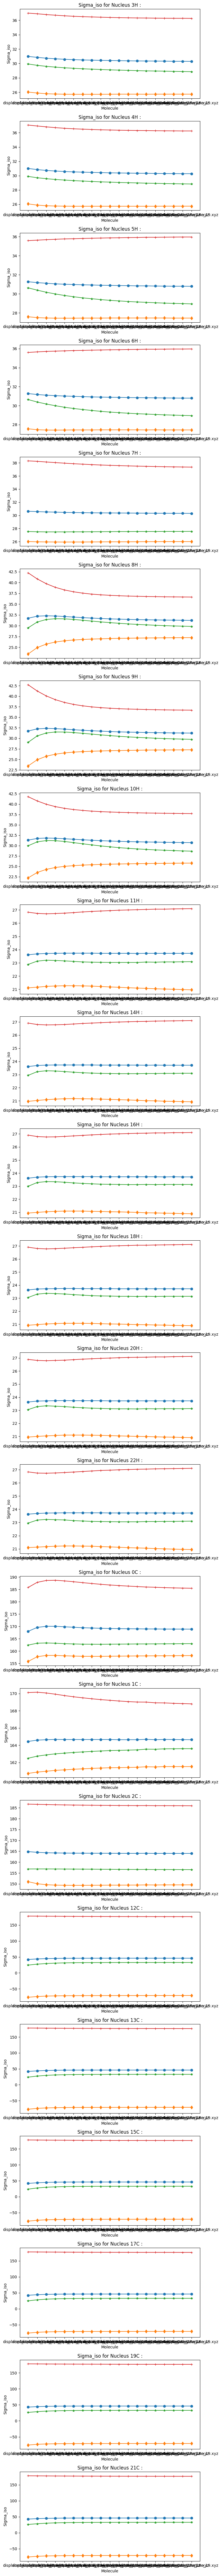

In [54]:
unique_nuclei = df['Atom'].unique()

# Define number of subplots
num_nuclei = len(unique_nuclei)

# Create subplots
fig, axs = plt.subplots(num_nuclei, 1, figsize=(8, 4 * num_nuclei))

# If only one nucleus, axs is not a list, so convert it to list for consistency
if num_nuclei == 1:
    axs = [axs]

# Loop through each unique nucleus and create a plot
for i, nucleus in enumerate(unique_nuclei):
    # Filter data for the current nucleus
    nucleus_data = df[df['Atom'] == nucleus]
    
    # Plot sigma_iso against molecule index or name
    axs[i].plot(nucleus_data['Molecule'], nucleus_data['sigma_iso'], marker='o')
    axs[i].plot(nucleus_data['Molecule'], nucleus_data['sigma_11'], marker='d')
    axs[i].plot(nucleus_data['Molecule'], nucleus_data['sigma_22'], marker='*')
    axs[i].plot(nucleus_data['Molecule'], nucleus_data['sigma_33'], marker='+')
    
    # Set labels and title
    axs[i].set_title(f'Sigma_iso for {nucleus}')
    axs[i].set_xlabel('Molecule')
    axs[i].set_ylabel('Sigma_iso')

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Plot data from dataframes

csv_files = glob.glob('dataframe_job*.csv')  # Adjust the pattern if necessary

for job_index, file in enumerate(csv_files):
    
    df = pd.read_csv(file, header=None, names=['Nucleus', 's_iso', 'σ_11', 'σ_22', 'σ_33', 'Symmetry'])

    for _, row in df.iterrows():
        nucleus = row['Nucleus'].strip()
        s_iso = row['s_iso']
        sigma_11 = row['σ_11']
        sigma_22 = row['σ_22']
        sigma_33 = row['σ_33']

        if nucleus not in nucleus_data:
            nucleus_data[nucleus] = []
        
        # Append the s_iso value for this job_index
        nucleus_data[nucleus].append(s_iso)
        
for nucleus, s_iso_values in nucleus_data.items():
    plt.figure()
    plt.plot(range(len(s_iso_values)), s_iso_values, marker='o')
    plt.title(f's_iso values for {nucleus}')
    plt.xlabel('Job Index')
    plt.ylabel('s_iso')

    plt.show() 
    plt.clf()

## Modules: MolView

here some text

In [ ]:
# molecule = 'D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/test_structs/benzene_H2O.xyz'
molecule = 'C:/Users/ettor/Desktop/NONCOV/scratch/test_structs/benzene_H2O.xyz'

MolView().plot_3d_molecule(molecule)

In [ ]:
# Plot euler angles and rotated tensor
tensor_pas = np.diag([1.0, 2.0, 3.0])  # Diagonal tensor in PAS
alpha, beta, gamma = 30, 45, 60  # Euler angles in degrees
MolView.plot_3D_tensors_and_axes(tensor_pas, alpha, beta, gamma)


## Modules: NMRFunctions

here some text

In [ ]:
# Tensor to Euler angles
mode = 'AZYZ'
order = 'Ascending'
alpha, beta, gamma, tensor_pas = NMRFunctions().tensor_to_euler(shielding_tensor, eigenvals, eigenvecs, symmetry, mode, order)

In [ ]:
# Generate equivalent sets of angles
NMRFunctions().EqEulerSet(alpha,beta,gamma)

## Modules: MolecularGraph

In [ ]:
fragment1 =(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
fragment2 = (13, 14, 15)

mol_graph = MolecularGraph()

# Parse the XYZ file
atom_types, coordinates = mol_graph.parse_xyz(mol_dir)

# Calculate pairwise distances
distances = mol_graph.calculate_distances(coordinates)

# Detect covalent bonds
covalent_bonds = mol_graph.detect_bonds(atom_types, distances)

# Detect non-covalent interactions
noncovalent_interactions = mol_graph.detect_noncovalent_interactions(atom_types, distances)

# Build the molecular graph
#mol_graph = mol_graph.build_molecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)

# Visualize the molecular graph
#mol_graph.draw()

# Plots 
mol_graph.plot_bond_dist_matrix(covalent_bonds, distances, atom_types)
mol_graph.plot_noncov_distance_map(noncovalent_interactions, atom_types)

# Build different graphs
covalent_bonds_graph = mol_graph.build_covalent_bonds_graph(atom_types, coordinates, covalent_bonds)
intramolecular_graph = mol_graph.build_intramolecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)
intermolecular_graph = mol_graph.build_intermolecular_graph(atom_types, coordinates, noncovalent_interactions)

# Draw subplots while preserving atom positions
mol_graph.draw_subplots(covalent_bonds_graph, intramolecular_graph, intermolecular_graph, coordinates)


threshold = 1.6

## Modules: DistanceScanner & RotationScanner

In [ ]:
# WORKING WITH RELATIVE PATHS 
current_dir = os.getcwd()
print(current_dir)

# LOGS AND ERRORS
error_log_file = 'error_log_file.txt' # to finish
log_file = 'log_file.txt' # to finish


# START TIMER: COMPUTE EFFECTIVE WALL TIME
start = timer() # this is not in [sec] i think

# SECTON: MAIN
def main():

    # Relative paths
    start_structure = os.path.join(current_dir, 'input_structures/KLaL_cation_pi_RCCE_opt_NICS.xyz')
    centroid_out = os.path.join(current_dir, 'centroid_output/centroid_file.xyz')
    input_file = os.path.join(current_dir, 'input_file/input_file.txt')

    # Read xyz file: this should be either a fully optimized geometry or one with relaxed H
    coordinates, atom_identities = read_atomic_coord(start_structure)
    print(f'Starting coordinates: {coordinates}')
    print(f'Atom identities: {atom_identities}')

    # Assign coordinates to molecular fragments, check nomenclature of your atoms in avogadro or any other molecular graphics soft
    coords1, coords2 = assign_molecule_fragments(coordinates, input_file)

    # Concatenate coordinates for k-means clustering
    all_coords = np.concatenate((coords1, coords2), axis=0)
    # print(f'All coords: {all_coords}')

    # Count how many fragments you have defined in the input file, important for accurate K-means clustering
    n_fragments = count_fragments(input_file)
    print(f"Number of '$fragment' occurrences: {n_fragments}")

    # Perform k-means clustering to compute centroids
    kmeans = KMeans(n_clusters=n_fragments) # K-means clusters = number of centroids = number of fragments
    kmeans.fit(all_coords)
    centroids = kmeans.cluster_centers_

    # Compute centroids for each fragment
    fragment_centroids = calculate_centroids([coords1, coords2])

    # Write centroid coordinates to file
    write_centroids(centroid_out, fragment_centroids)
    print(f'Centroid coordinates: {fragment_centroids}')

    # Calculate displacement direction (line connecting centroids)
    displacement_direction = centroids[1] - centroids[0]
    displacement_direction /= np.linalg.norm(displacement_direction)
    print(f'Displacement direction:{displacement_direction}')

    # Read displacement step size from input file
    displacement_step = None
    with open(input_file, 'r') as f:
        lines = f.readlines()
        read_displacement = False
        for line in lines:
            if read_displacement:
                displacement_values = line.strip().split()
                if displacement_values:
                    displacement_step = float(displacement_values[0])
                    break
            elif line.strip() == "$displacement":
                read_displacement = True

    if displacement_step is None:
        print('ERROR: displacement step size not found in input file, please specify it! Syntax => $displacement + number')
        return
    print(f'Displacement step is: {displacement_step}') # please doublecheck that it is the same value you defined in the input

    # Displace the first fragment iteratively and save each structure
    displaced_fragment_coords = coords1.copy()  # Make a copy of the original coordinates of the fragment that is displaced
    print(f'Original coordinates displaced fragment:', displaced_fragment_coords)

    # Initialize the coordinates for the fixed fragment (e.g., coords2)
    coords_fixed = coords2.copy() # make a copy of the fixed fragment coordinates to append to the displaced ones
    print(f'Original coordinates fixed fragment:', coords_fixed)

    all_displaced_fragment_coords = [displaced_fragment_coords]  # List to store all displaced structures

    # Combine displaced coordinates with original ones
    all_combined_coords = [np.concatenate((coords_fixed, displaced_fragment_coords), axis=0)]  # List to store all combined structures

    fragment_centroids = [fragment_centroids[0]]  # List to store all centroids

    # Dissociation limit NEED AT LEAST 40 OF THEM MINIMUM
    diss_lim = 50 # change with the output value in agnstrom from func(dissociation_limit)

    for i in range(1, diss_lim):  # Iterate 50 times (adjust the number as needed) put this as to be the dissociation limit of each DFT run
        
        displacement_vector = [] 

        # Compute new set of coordinates for displaced fragments, change $displacement value in input file to tune the displacement
        displaced_fragment_coords = displace_fragment(coords1, displacement_direction, displacement_step, i)
        #print(f'Displaced fragment coord is: {displaced_fragment_coords}')

        combined_coords = np.concatenate((coords_fixed, displaced_fragment_coords), axis=0)
        all_combined_coords.append(combined_coords)

        # Update centroids for the displaced structure
        fragment_centroid = calculate_centroids([displaced_fragment_coords])
        fragment_centroids.append(fragment_centroid[0])
        print(f'Updated centroids:', fragment_centroid)

        # Write displaced structure to file
        output_file = Path(os.path.join(current_dir, f'displaced_structures/displaced_structure_{i}.xyz'))
        write_displaced_xyz_file(output_file, coords_fixed, displaced_fragment_coords, atom_identities)

        all_displaced_fragment_coords.append(displaced_fragment_coords)

        # Compute distance between the fixed fragment centroid and all the atoms from the displaced fragment
        centroid_to_displaced_distance = compute_distance_from_centroid(displaced_fragment_coords, centroids)
        print(f'Distance between displaced coordinates and centroid is: {centroid_to_displaced_distance}')

        # Write distances to file - needed for DFT calculations outputs
        distance_output_file = Path(os.path.join(current_dir, f'distance_files/distances_structures_{i}.xyz'))
        write_distances_file(distance_output_file, displaced_fragment_coords, centroid_to_displaced_distance, atom_identities, displacement_step)


    # Plot initial topology for molecular fragments and centroids
    fig = plot_starting_molecular_fragments(coords1, coords2, centroids)

    # Generate colors for the plots based on displacement iteration
    num_iterations = len(all_displaced_fragment_coords)
    colors = plt.cm.viridis(np.linspace(0.2, 1.0, num_iterations))

    # Plot displaced molecular fragments and centroids
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot original fragments and centroids
    ax.scatter(coords1[:, 0], coords1[:, 1], coords1[:, 2], color=colors[0], label='Molecule 1 (Original)')
    ax.scatter(coords2[:, 0], coords2[:, 1], coords2[:, 2], color=colors[0], label='Molecule 2 (Original)')
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], color=colors[0], marker='x', s=100, label='Centroids (Original)')

    # Plot displaced fragments and centroids
    for i, displaced_coords in enumerate(all_displaced_fragment_coords[1:], start=1):
        color = colors[i]
        label = f'Iteration {i}'
        ax.scatter(displaced_coords[:, 0], displaced_coords[:, 1], displaced_coords[:, 2], color=color, label=label)
        ax.scatter(fragment_centroids[i][0], fragment_centroids[i][1], fragment_centroids[i][2], color=color, marker='x', s=100, label=f'Centroids ({label})')

    ax.legend()
    plt.show()


    # END TIMER: STOP TIMER AND PRINT
    elapsed_time = timer() - start  # in seconds
    print(f'Elapsed time for the code to run is: {elapsed_time}')


if __name__ == '__main__':
    main()


## Modules: AminoStat

In [ ]:
# # Example usage
# toolbox = NONCOVToolbox()
# amino_stats = toolbox.AminoStat()

# # Example usage
# current_dir = os.getcwd()

# protein_sequence = os.path.join(current_dir, 'scratch/amino_acid_stats/spidersilks.txt')
# spaced_sequence = os.path.join(current_dir, 'scratch/amino_acid_stats/spaced_spidersilks.txt')
# count_file = os.path.join(current_dir, 'scratch/amino_acid_stats/silks_amino_acid_count.txt')
# plot_file = os.path.join(current_dir, 'scratch/amino_acid_stats/silks_amino_acid_statistics.pdf')

# #amino_stats = AminoStat()

# amino_stats.space_prot_seq(protein_sequence, spaced_sequence)
# amino_stats.count_amino_acids(spaced_sequence, count_file)
# amino_stats.plot_amino_acid_statistics(count_file, plot_file)

# amino_stats.define_protein_domains()


## Here xtb, CENSO, CREST